In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy import interpolate
import scipy
import scipy.special
import scipy.integrate

In [2]:
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

In [86]:
#z_pk = [200.0,100.0,75.0,50.0,10.0,5.0,0.0]
z_pk = [300., 100.0,10.0,5.0,3.0,1.0,0.5,0.0]
z_init = 100.
kout = [1e-5]
cosmo = Class()
cosmo.set({'output':'mPk dTk vTk lTk', 
           'z_pk':str(z_pk).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'switch_radiation_source':1,
                  'switch_dr_source':1,
           'switch_gamma':1,
#           'tight_coupling_approximation':0,
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':3,
           'l_max_g':200,
           'l_max_ur':200,
           'l_max_pol_g':200, 
           'k_output_values':str(kout).strip('[]'),
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':100,
           'k_per_decade_for_bao':200,
           'gauge' : 'Newtonian',
           'P_k_max_1/Mpc' : 1.1,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-4,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.24*1+1e-6,
#                  'start_sources_at_tau_c_over_tau_h':0.004,
#                  'start_small_k_at_tau_c_over_tau_h':0.000015,
#           'tight_coupling_trigger_tau_c_over_tau_h':0.00015
#           'N_ur':0.00001, 'YHe':0.25
            })
#for key, val in cosmo.pars.iteritems():
#    print key,' = ',val
cosmo.compute()

In [41]:
bg = cosmo.get_background()
print bg.keys()

grow_interp_z = interpolate.interp1d(bg['z'],bg['grow'])
decay_interp_z = interpolate.interp1d(bg['z'],bg['bwdec'])
rho_cdm_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_cdm'])
rho_b_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_b'])
rho_lambda_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_lambda'])
rho_ur_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_ur'])
rho_g_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_g'])

D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)


['(.)rho_crit', 'grow_prime', 'bwdec', '(.)rho_cdm', 'H_prime', '(.)rho_ur', 'ang.diam.dist.', 'proper time [Gyr]', 'H [1/Mpc]', 'conf. time [Mpc]', 'bwdec_prime', 'lum. dist.', 'gr.fac. f', 'comov.snd.hrz.', 'grow', 'comov. dist.', 'Wronskian', '(.)rho_lambda', 'decay', '(.)rho_b', '(.)rho_g', 'gr.fac. D', 'z']


['HCtheta_prime', 'L_prime', 'B_nm', 'A_nm', 'delta_ur', 'CHT_decay', 'delta_cdm', 'theta_cdm', 'CHT_grow', 'theta_ur', 'HCAnb_prime', 'HCAnb', 'phi', 'psi', 'H_T_nm', 'shear_ur', 'HCtheta', 'L', 'delta_g', 'H_L_nm', 'delta_b', 'a', 'theta_g', 'pol0_g', 'theta_b', 'shear_g', 'tau [Mpc]', 'delta_N', 'pol2_g', 'pol1_g']
521.558011539


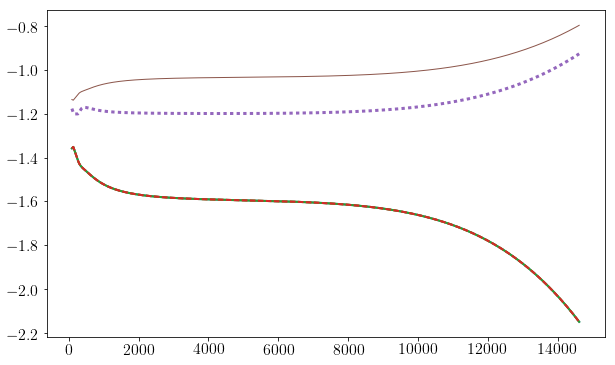

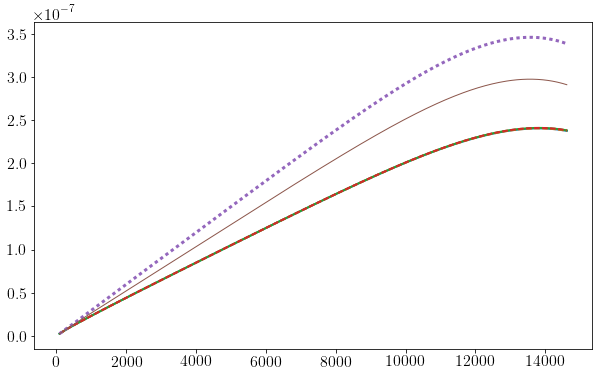

In [23]:
pt = cosmo.get_perturbations()['scalar'][0]

R_nu = bg['(.)rho_ur'][-1]/(bg['(.)rho_ur'][-1]+bg['(.)rho_g'][-1])
psi = pt['phi']/(1.+2./5.*R_nu)
print pt.keys()
plt.plot(pt['tau [Mpc]'],pt['delta_ur'])
plt.plot(pt['tau [Mpc]'],pt['delta_g'],ls='--')
plt.plot(pt['tau [Mpc]'],4./3.*pt['delta_cdm'])
plt.plot(pt['tau [Mpc]'],4./3.*pt['delta_b'],ls='--')
plt.plot(pt['tau [Mpc]'],-2*pt['psi'],ls=':',lw=3)
plt.plot(pt['tau [Mpc]'],-2*psi,ls='-',lw=1)
#plt.xlim([0,500])

plt.figure()
plt.plot(pt['tau [Mpc]'],pt['theta_ur'])
plt.plot(pt['tau [Mpc]'],pt['theta_g'],ls='--')
plt.plot(pt['tau [Mpc]'],pt['theta_cdm'])
plt.plot(pt['tau [Mpc]'],pt['theta_b'],ls='--')
plt.plot(pt['tau [Mpc]'],0.5*kout[0]**2*pt['tau [Mpc]']*pt['psi'],ls=':',lw=3)
plt.plot(pt['tau [Mpc]'],0.5*kout[0]**2*pt['tau [Mpc]']*psi,ls='-',lw=1)
#plt.xlim([0,500])
#plt.ylim(0.,1e-8)
print pt['tau [Mpc]'][100]

['HCtheta_prime', 'L_prime', 'B_nm', 'A_nm', 'delta_ur', 'CHT_decay', 'delta_cdm', 'theta_cdm', 'CHT_grow', 'theta_ur', 'HCAnb_prime', 'HCAnb', 'phi', 'psi', 'H_T_nm', 'shear_ur', 'HCtheta', 'L', 'delta_g', 'H_L_nm', 'delta_b', 'a', 'theta_g', 'pol0_g', 'theta_b', 'shear_g', 'tau [Mpc]', 'delta_N', 'pol2_g', 'pol1_g']
487.146048081


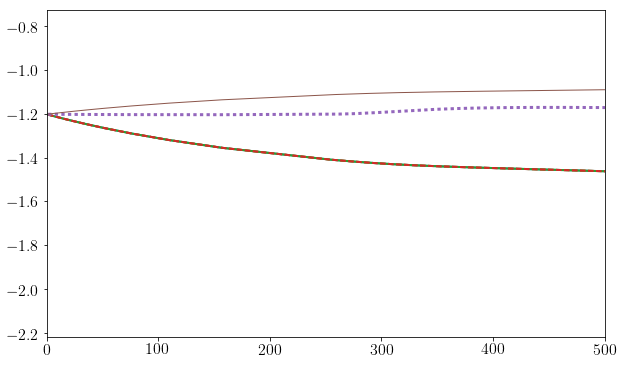

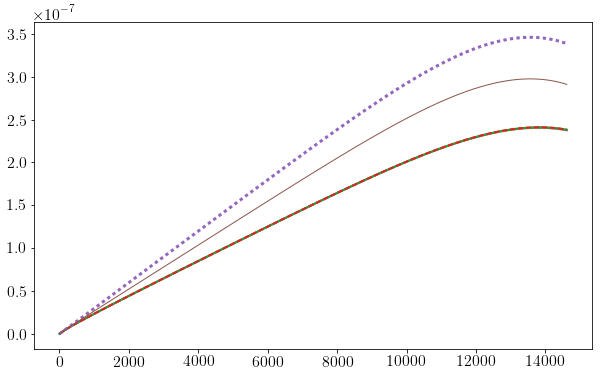

In [11]:
pt = cosmo.get_perturbations()['scalar'][0]

R_nu = bg['(.)rho_ur'][-1]/(bg['(.)rho_ur'][-1]+bg['(.)rho_g'][-1])
psi = pt['phi']/(1.+2./5.*R_nu)
print pt.keys()
plt.plot(pt['tau [Mpc]'],pt['delta_ur'])
plt.plot(pt['tau [Mpc]'],pt['delta_g'],ls='--')
plt.plot(pt['tau [Mpc]'],4./3.*pt['delta_cdm'])
plt.plot(pt['tau [Mpc]'],4./3.*pt['delta_b'],ls='--')
plt.plot(pt['tau [Mpc]'],-2*pt['psi'],ls=':',lw=3)
plt.plot(pt['tau [Mpc]'],-2*psi,ls='-',lw=1)
plt.xlim([0,500])

plt.figure()
plt.plot(pt['tau [Mpc]'],pt['theta_ur'])
plt.plot(pt['tau [Mpc]'],pt['theta_g'],ls='--')
plt.plot(pt['tau [Mpc]'],pt['theta_cdm'])
plt.plot(pt['tau [Mpc]'],pt['theta_b'],ls='--')
plt.plot(pt['tau [Mpc]'],0.5*kout[0]**2*pt['tau [Mpc]']*pt['psi'],ls=':',lw=3)
plt.plot(pt['tau [Mpc]'],0.5*kout[0]**2*pt['tau [Mpc]']*psi,ls='-',lw=1)
#plt.xlim([0,500])
#plt.ylim(0.,1e-8)
print pt['tau [Mpc]'][100]


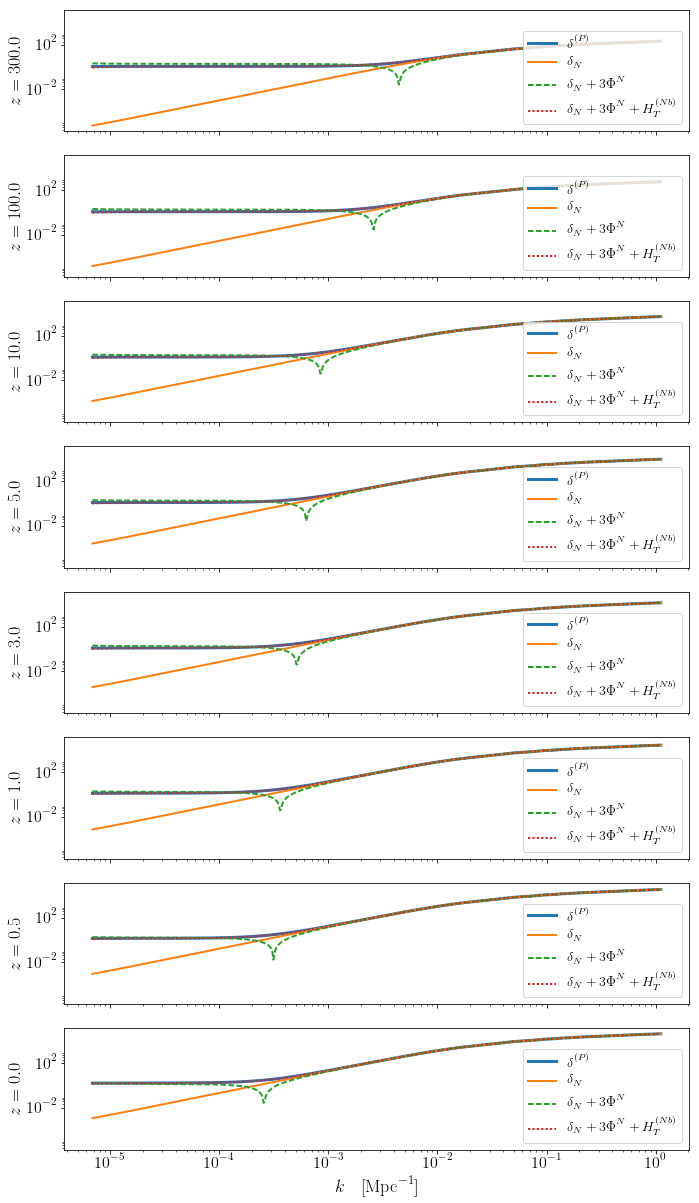

In [98]:
zvec = z_pk
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True,sharey=True)
tk0 = cosmo.get_transfer(0.)
CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    axes[iz].loglog(k,np.abs(delta_P),label=r'$\delta^{(P)}$',lw=3)
    axes[iz].loglog(k,np.abs(delta_N),label=r'$\delta_N$')
    axes[iz].loglog(k,np.abs(delta_N+3*Phi_N),label=r'$\delta_N + 3\Phi^N$',ls='--')
    axes[iz].loglog(k,np.abs(delta_N+3*Phi_N+H_T_nb),label=r'$\delta_N + 3\Phi^N + H_T^{(Nb)}$',ls=':',lw=2)
    #axes[iz].semilogx(k,delta_P,label=r'$\delta^{(P)}$',lw=3)
    #axes[iz].semilogx(k,delta_N,label=r'$\delta_N$')
    #axes[iz].semilogx(k,delta_N+3*Phi_N,label=r'$\delta_N + 3\Phi^N$',ls='--')
    #axes[iz].semilogx(k,delta_N+3*Phi_N+H_T_nb,label=r'$\delta_N + 3\Phi^N + H_T^{(Nb)}$',ls=':',lw=2)
    
    
    axes[iz].legend(loc='lower right')
    axes[iz].set_ylabel(r'$z='+str(z)+'$')
    #axes[iz].set_yscale('symlog',linthreshy=1e-1)

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
f.tight_layout()
f.savefig('delta1.pdf')
#lgd = axes[1].legend(fontsize=fs,loc='upper center',ncol=len(zvec),
#                bbox_to_anchor=(0.5, 1.6), handletextpad=0.1)

#        axes[0].set_ylim([-4,1])
#f.subplots_adjust(wspace=0.5)

#f.savefig('H_T_influence.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

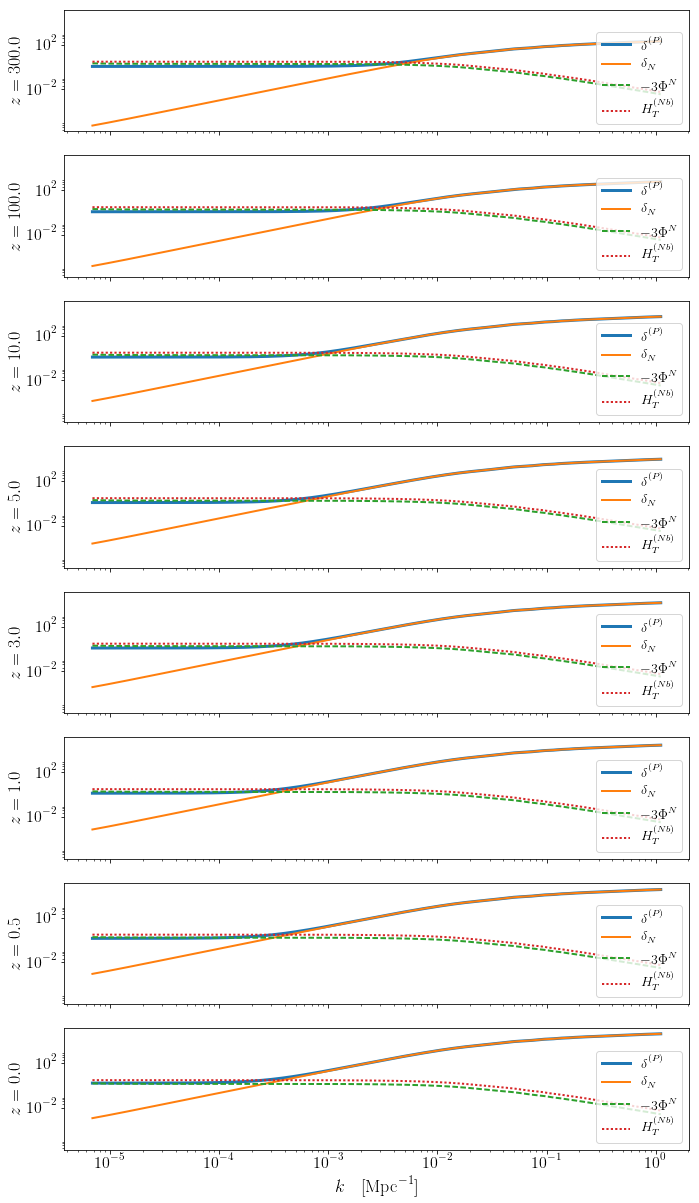

In [99]:
zvec = z_pk
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True,sharey=True)
tk0 = cosmo.get_transfer(0.)
CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    fac = 1.0#-1./k**2
    axes[iz].semilogx(k,-delta_P,label=r'$\delta^{(P)}$',lw=3)
    axes[iz].semilogx(k,-delta_N,label=r'$\delta_N$')
    axes[iz].semilogx(k,3*Phi_N,label=r'$-3\Phi^N$',ls='--')
    axes[iz].semilogx(k,-H_T_nb,label=r'$H_T^{(Nb)}$',ls=':',lw=2)
    
    
    axes[iz].legend(loc='lower right')
    axes[iz].set_ylabel(r'$z='+str(z)+'$')
    axes[iz].set_yscale('log',linthreshy=1e-1)

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
f.tight_layout()
f.savefig('delta2.pdf')
#lgd = axes[1].legend(fontsize=fs,loc='upper center',ncol=len(zvec),
#                bbox_to_anchor=(0.5, 1.6), handletextpad=0.1)

#        axes[0].set_ylim([-4,1])
#f.subplots_adjust(wspace=0.5)

#f.savefig('H_T_influence.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

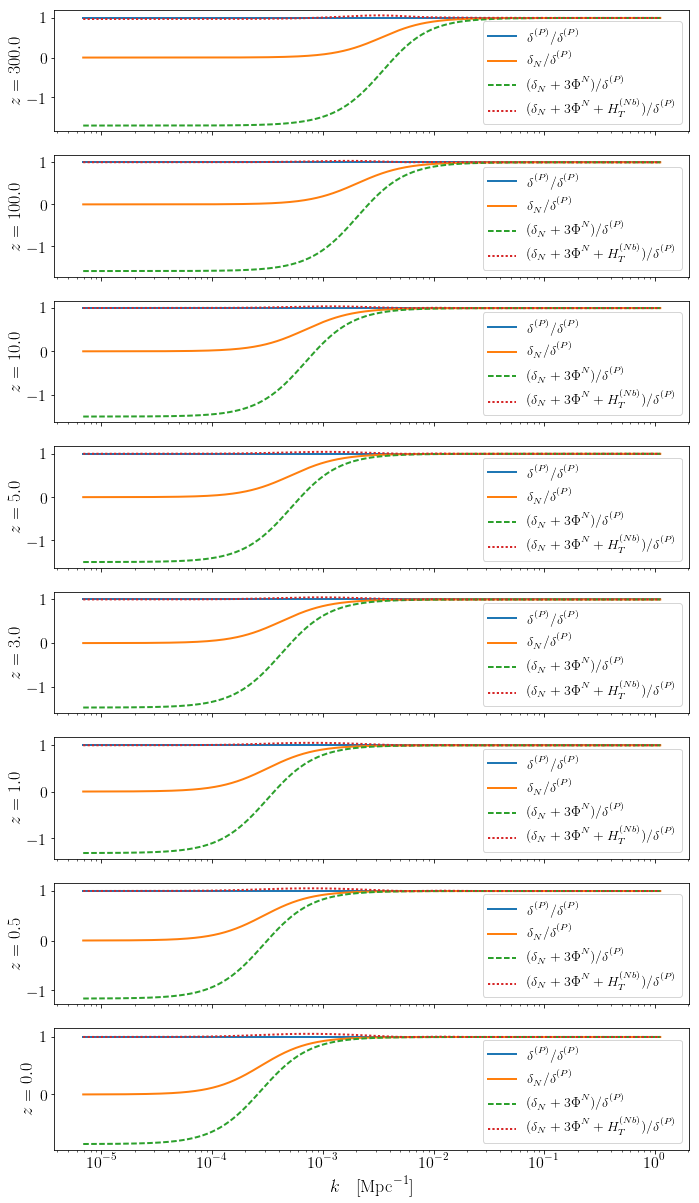

In [24]:
zvec = z_pk
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True)
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()

CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    axes[iz].semilogx(k,delta_P/delta_P,label=r'$\delta^{(P)}/\delta^{(P)}$')
    axes[iz].semilogx(k,delta_N/delta_P,label=r'$\delta_N/\delta^{(P)}$')
    axes[iz].semilogx(k,(delta_N+3*Phi_N)/delta_P,label=r'$(\delta_N + 3\Phi^N)/\delta^{(P)}$',ls='--')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_nm)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
    
    axes[iz].legend(loc='lower right')
    axes[iz].set_ylabel(r'$z='+str(z)+'$')

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
f.tight_layout()
f.savefig('delta3.pdf')

['(.)rho_crit', 'grow_prime', 'bwdec', '(.)rho_cdm', 'H_prime', '(.)rho_ur', 'ang.diam.dist.', 'proper time [Gyr]', 'H [1/Mpc]', 'conf. time [Mpc]', 'bwdec_prime', 'lum. dist.', 'gr.fac. f', 'comov.snd.hrz.', 'grow', 'comov. dist.', 'Wronskian', '(.)rho_lambda', 'decay', '(.)rho_b', '(.)rho_g', 'gr.fac. D', 'z']


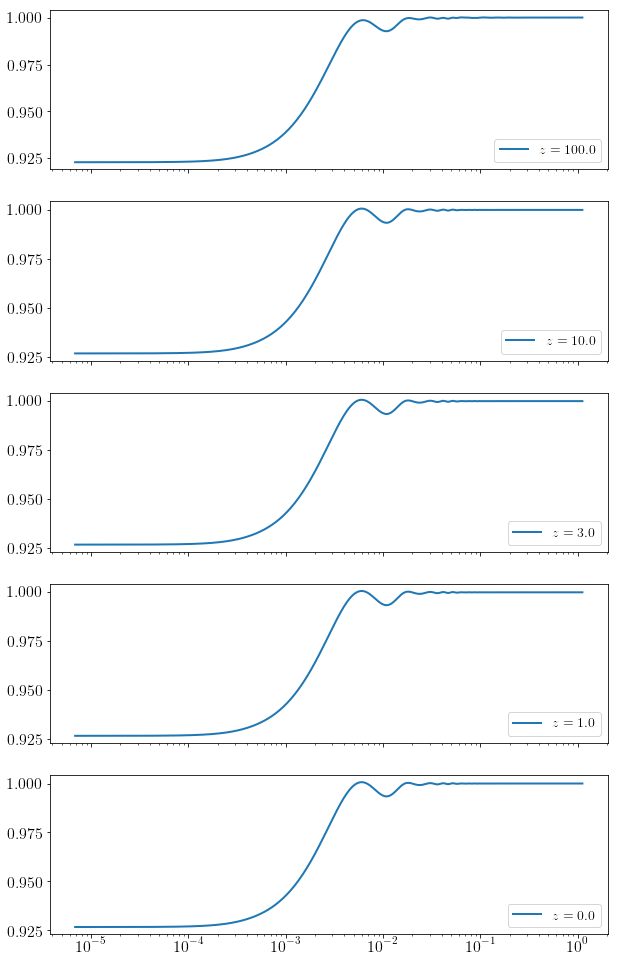

In [42]:
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

tk0 = cosmo.get_transfer(0.)

print bg.keys()
for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    delta_N = tk['delta_N']
    delta_Nbs = (tk0['delta_N']-k*tk0['L'])*D(a)
    #axes[iz].loglog(k,-delta_N/k/k)
    #axes[iz].loglog(k,-delta_Nbs/k/k)
    axes[iz].semilogx(k,delta_N/delta_Nbs,label=r'$z = '+str(z)+'$')
    axes[iz].legend(loc='lower right')
f.savefig('delta_Nbs.pdf')

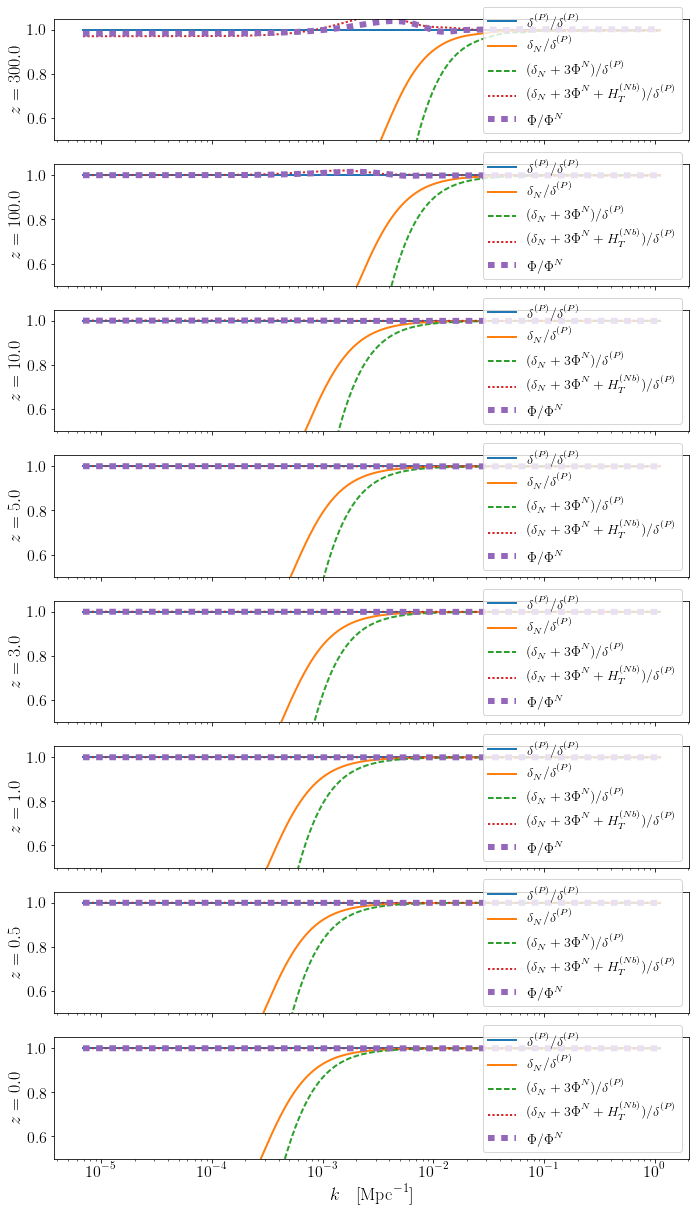

In [25]:
zvec = z_pk
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True,sharey=True)
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

Hubble = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H [1/Mpc]'],s=0,k=1)
Hubble_prime = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H_prime'],s=0,k=1)


CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    rho_lambda = rho_lambda_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(Hubble(a)**2-rho_lambda)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    
    phi = tk['phi']
    #print Hubble(a)**2,phi[100]/Phi_N[100]
    #print (rho_cdm+rho_b),delta_N[100],tk['d_tot'][100]
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    axes[iz].semilogx(k,delta_P/delta_P,label=r'$\delta^{(P)}/\delta^{(P)}$')
    axes[iz].semilogx(k,delta_N/delta_P,label=r'$\delta_N/\delta^{(P)}$')
    axes[iz].semilogx(k,(delta_N+3*Phi_N)/delta_P,label=r'$(\delta_N + 3\Phi^N)/\delta^{(P)}$',ls='--')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
    axes[iz].semilogx(k,phi/Phi_N,label=r'$\Phi/\Phi^N$',ls=':',lw=6)
    
    axes[iz].legend(loc='lower right')
    axes[iz].set_ylabel(r'$z='+str(z)+'$')

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
#axes[-1].set_xlim([1.5e-3,1.0])
axes[-1].set_ylim([0.5,1.05])

f.tight_layout()
f.savefig('delta3b.pdf')

In [103]:
print tk0.keys()
print bg.keys()

['t_ur', 'psi', 'delta_N', 't_cdm', 'theta_Nb', 't_b', 'd_tot', 'L_prime', 't_g', 'L', 'phi', 'theta_N', 'd_ur', 'delta_Nb', 'd_cdm', 'd_b', 't_tot', 'd_g', 'k (h/Mpc)']
['(.)rho_crit', 'grow_prime', 'bwdec', '(.)rho_cdm', 'H_prime', '(.)rho_ur', 'ang.diam.dist.', 'proper time [Gyr]', 'H [1/Mpc]', 'conf. time [Mpc]', 'bwdec_prime', 'lum. dist.', 'gr.fac. f', 'comov.snd.hrz.', 'grow', 'comov. dist.', 'Wronskian', '(.)rho_lambda', 'decay', '(.)rho_b', '(.)rho_g', 'gr.fac. D', 'z']


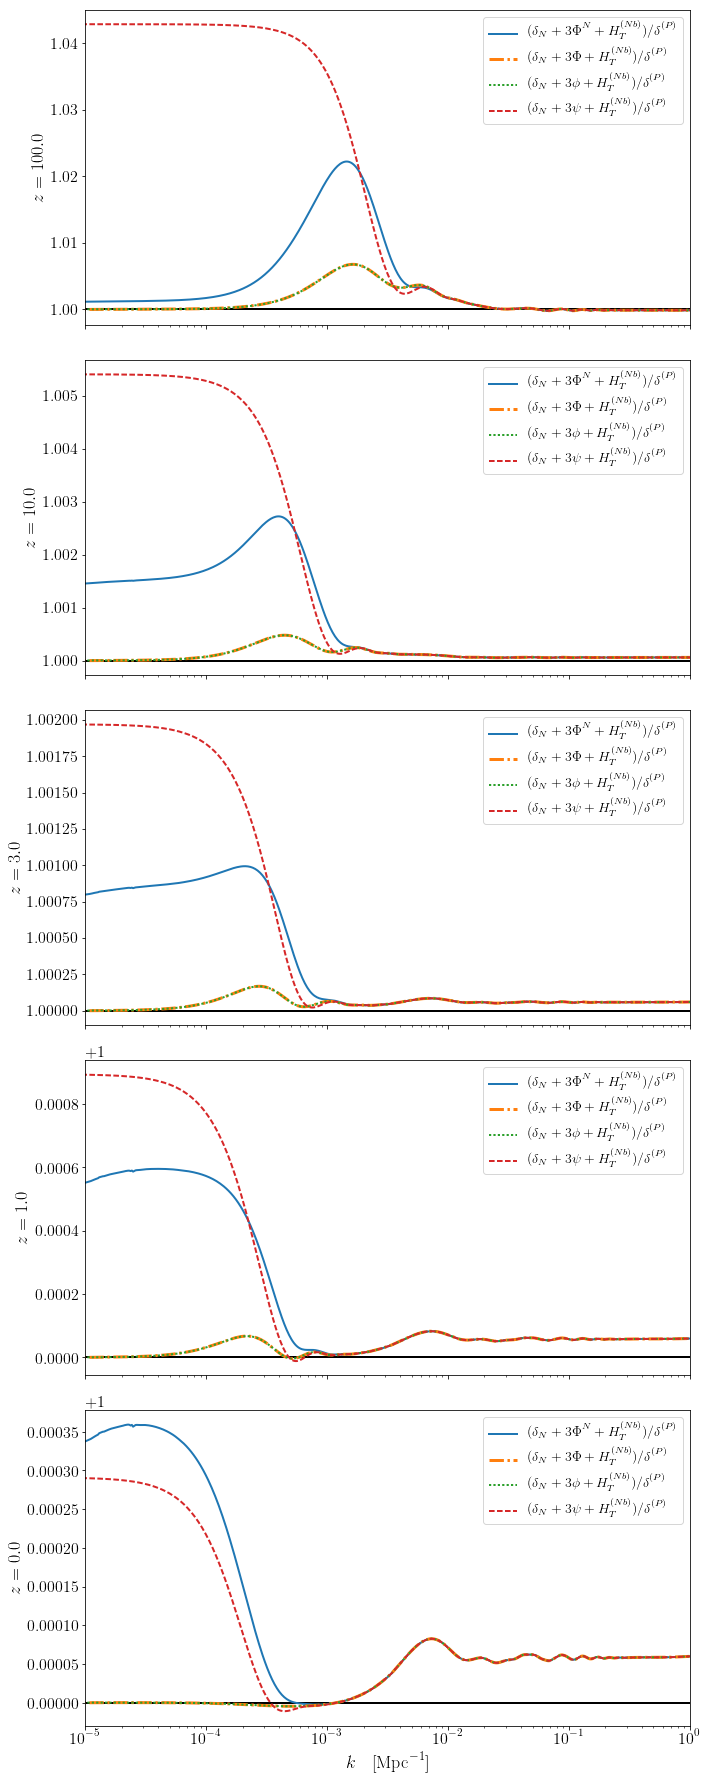

In [44]:
zvec = z_pk
zvec = [100.0,10.0,3.0,1.0,0.0]
f, axes = plt.subplots(len(zvec),1,figsize=(10,25),sharex=True,sharey=False)
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

Hubble = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H [1/Mpc]'],s=0,k=1)
Hubble_prime = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H_prime'],s=0,k=1)


CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    if False:
        rho_cdm = rho_cdm_interp_z(z)
        rho_b = rho_b_interp_z(z)
        rho_g = rho_g_interp_z(z)
        rho_ur = rho_ur_interp_z(z)
    else:
        rho_cdm = bg['(.)rho_cdm'][-1]/a**3
        rho_b = bg['(.)rho_b'][-1]/a**3
        rho_g = bg['(.)rho_g'][-1]/a**4
        rho_ur = bg['(.)rho_ur'][-1]/a**4
    
    rho_lambda = rho_lambda_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)+3*a*Hubble(a)*(rho_cdm+rho_b+4./3.*(rho_g+rho_ur))*tk['t_tot']/k/k)
    phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)+
                             3*a*cosmo.Hubble(1./a-1.)*(rho_cdm+rho_b+4./3.*(rho_g+rho_ur))*tk['t_tot']/k/k)
    rho_delta = 0.
    rho_plus_p_theta =0.
    rhop={}
    rhop['cdm'] = [rho_cdm, 0.]
    rhop['b'] = [rho_b, 0.]
    rhop['ur'] = [rho_ur, 1./3.*rho_ur]
    rhop['g'] = [rho_g, 1./3.*rho_g]
    for species in ['cdm','b','g','ur']:
        rho_delta += tk['d_'+species]*rhop[species][0]
        rho_plus_p_theta +=tk['t_'+species]*sum(rhop[species])
    
    phi = -3./(2.*k**2)*a*a*(rho_delta+3.0*a*cosmo.Hubble(z)*rho_plus_p_theta/k/k)
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(Hubble(a)**2-rho_lambda)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    
    phi_tk = tk['phi']
    psi_tk = tk['psi']
    
    #print Hubble(a)**2,phi[100]/Phi_N[100]
    #print (rho_cdm+rho_b),delta_N[100],tk['d_tot'][100]
    #print z, (rho_cdm+rho_b)*delta_N[0], rho_g*tk['d_g'][0]
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    axes[iz].axhline(1,ls='-',color='k')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nb)})/\delta^{(P)}$',ls='-')
    axes[iz].semilogx(k,(delta_N+3*phi+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi + H_T^{(Nb)})/\delta^{(P)}$',ls='-.',lw=3)
    #axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_bs)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Bs)})/\delta^{(P)}$',ls='--')
    #axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_nm)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nm)})/\delta^{(P)}$',ls=':')
    #axes[iz].semilogx(k,phi/Phi_N,label=r'$\Phi/\Phi^N$',ls=':',lw=6)
    axes[iz].semilogx(k,(delta_N+3*phi_tk+H_T_nb)/delta_P,label=r'$(\delta_N + 3\phi + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
    axes[iz].semilogx(k,(delta_N+3*psi_tk+H_T_nb)/delta_P,label=r'$(\delta_N + 3\psi + H_T^{(Nb)})/\delta^{(P)}$',ls='--')
    #axes[iz].semilogx(k,phi/phi_tk,label=r'$\Phi/\phi$',ls='-')
    
    axes[iz].legend(loc='upper right',ncol=1)
    axes[iz].set_ylabel(r'$z='+str(z)+'$')

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
axes[-1].set_xlim([1e-5,1.0])
#axes[-1].set_ylim([0.98,1.05])

f.tight_layout()
f.savefig('delta5.pdf')

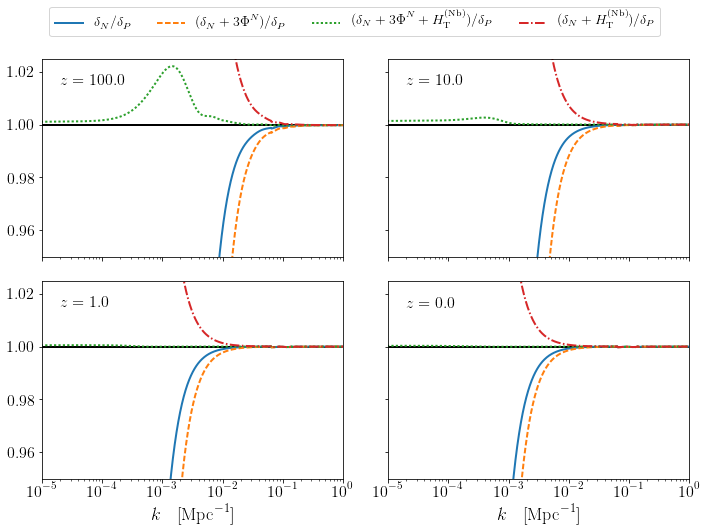

In [65]:
zvec = z_pk
zvec = [100.0,10.0,1.0,0.0]

f, axes = plt.subplots(len(zvec)//2,len(zvec)//2,figsize=(10,7),sharex=True,sharey=True)
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

Hubble = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H [1/Mpc]'],s=0,k=1)
Hubble_prime = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H_prime'],s=0,k=1)


CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

flatax = axes.flatten()
for iz, z in enumerate(zvec):
    ax = flatax[iz]
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    rho_lambda = rho_lambda_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(Hubble(a)**2-rho_lambda)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    ax.axhline(1.0,color='k')
    #axes[iz].semilogx(k,delta_P/delta_P,label=r'$\delta^{(P)}/\delta^{(P)}$')
    ax.semilogx(k,delta_N/delta_P,label=r'$\delta_N/\delta_P$')
    ax.semilogx(k,(delta_N+3*Phi_N)/delta_P,label=r'$(\delta_N + 3\Phi^N)/\delta_P$',ls='--')
    ax.semilogx(k,(delta_N+3*Phi_N+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_\mathrm{T}^\mathrm{(Nb)})/\delta_P$',ls=':')
    ax.semilogx(k,(delta_N+H_T_nb)/delta_P,
                      label=r'$(\delta_N + H_\mathrm{T}^\mathrm{(Nb)})/\delta_P$',ls='-.')
    #axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_bs)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Bs)})/\delta^{(P)}$',ls='-')
    #axes[iz].semilogx(k,phi/Phi_N,label=r'$\Phi/\Phi^N$',ls=':',lw=6)
    
    #ax.legend(loc='lower right')
    #ax.set_ylabel(r'$z='+str(z)+'$')
    ax.text(2e-5,1.015,r'$z='+str(z)+'$')

for ax in axes[-1,:]:
    ax.set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
    ax.set_xlim([1e-5,1.0])
    ax.set_ylim([0.95,1.025])

lgd = flatax[0].legend(loc='upper left',ncol=len(zvec), bbox_to_anchor=(0., 1.3))#, handletextpad=0.1)
f.tight_layout()

f.subplots_adjust(wspace=0.15)

f.savefig('delta_final.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')


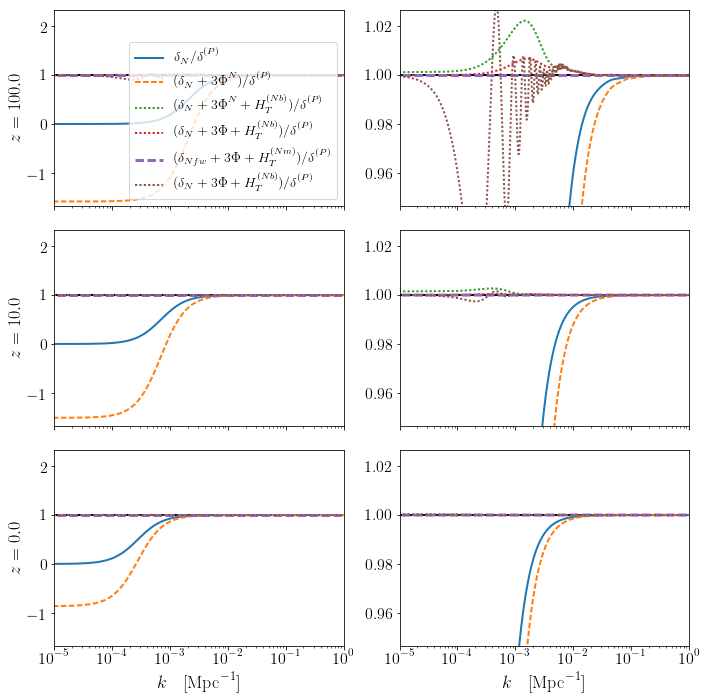

In [87]:
zvec = z_pk
zvec = [100.0,10.,0.0]
f, axes = plt.subplots(len(zvec),2,figsize=(10,10),sharex=True,sharey=False)
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

Hubble = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H [1/Mpc]'],s=0,k=1)
Hubble_prime = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H_prime'],s=0,k=1)


CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    if False:
        rho_cdm = rho_cdm_interp_z(z)
        rho_b = rho_b_interp_z(z)
        rho_g = rho_g_interp_z(z)
        rho_ur = rho_ur_interp_z(z)
    else:
        rho_cdm = bg['(.)rho_cdm'][-1]/a**3
        rho_b = bg['(.)rho_b'][-1]/a**3
        rho_g = bg['(.)rho_g'][-1]/a**4
        rho_ur = bg['(.)rho_ur'][-1]/a**4
    
    rho_lambda = rho_lambda_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)+3*a*Hubble(a)*(rho_cdm+rho_b+4./3.*(rho_g+rho_ur))*tk['t_tot']/k/k)
    phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)+
                             3*a*cosmo.Hubble(1./a-1.)*(rho_cdm+rho_b+4./3.*(rho_g+rho_ur))*tk['t_tot']/k/k)
    rho_delta = 0.
    rho_plus_p_theta =0.
    rhop={}
    rhop['cdm'] = [rho_cdm, 0.]
    rhop['b'] = [rho_b, 0.]
    rhop['ur'] = [rho_ur, 1./3.*rho_ur]
    rhop['g'] = [rho_g, 1./3.*rho_g]
    for species in ['cdm','b','g','ur']:
        rho_delta += tk['d_'+species]*rhop[species][0]
        rho_plus_p_theta +=tk['t_'+species]*sum(rhop[species])
    
    phi = -3./(2.*k**2)*a*a*(rho_delta+3.0*a*cosmo.Hubble(z)*rho_plus_p_theta/k/k)
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(Hubble(a)**2-rho_lambda)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    
    phi_tk = tk['phi']
    psi_tk = tk['psi']
    
    #print Hubble(a)**2,phi[100]/Phi_N[100]
    #print (rho_cdm+rho_b),delta_N[100],tk['d_tot'][100]
    #print z, (rho_cdm+rho_b)*delta_N[0], rho_g*tk['d_g'][0]
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    for j in range(2):
        axes[iz,j].axhline(1,ls='-',color='k')
        #axes[iz].semilogx(k,delta_P/delta_P,label=r'$\delta^{(P)}/\delta^{(P)}$')
        axes[iz,j].semilogx(k,delta_N/delta_P,label=r'$\delta_N/\delta^{(P)}$')
        axes[iz,j].semilogx(k,(delta_N+3*Phi_N)/delta_P,label=r'$(\delta_N + 3\Phi^N)/\delta^{(P)}$',ls='--')
        axes[iz,j].semilogx(k,(delta_N+3*Phi_N+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
        axes[iz,j].semilogx(k,(delta_N+3*phi_tk+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
        axes[iz,j].semilogx(k,(tk['delta_N']+3*phi_tk+H_T_nm)/delta_P,label=r'$(\delta_{Nfw} + 3\Phi + H_T^{(Nm)})/\delta^{(P)}$',ls='--',lw=3)
        axes[iz,j].semilogx(k,(delta_N+3*phi_tk+H_T_bs)/delta_P,label=r'$(\delta_N + 3\Phi + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
        
    axes[iz,0].set_ylabel(r'$z='+str(z)+'$')
    #axes[iz,1].set_ylim([0.98,1.05])
    axes[iz,0].set_ylim([-5./3.,7./3.])
    zoom = 0.02
    axes[iz,1].set_ylim([1-8./3.*zoom,1+4./3.*zoom])

for j in range(2):
    axes[-1,j].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
    axes[-1,j].set_xlim([1e-5,1.0])
axes[0,0].legend(loc='lower right',ncol=1)    
#

f.tight_layout()
f.savefig('delta_new.pdf')

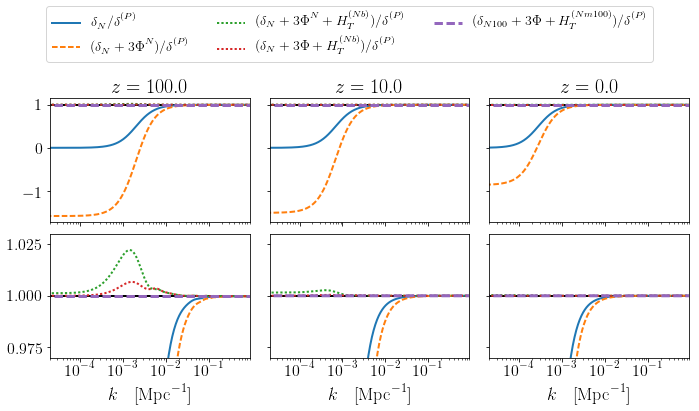

In [94]:
zvec = z_pk
zvec = [100.0,10.,0.0]

f, axes = plt.subplots(2,len(zvec),figsize=(10,5),sharex=True,sharey='row')
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

Hubble = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H [1/Mpc]'],s=0,k=1)
Hubble_prime = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H_prime'],s=0,k=1)


CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    if False:
        rho_cdm = rho_cdm_interp_z(z)
        rho_b = rho_b_interp_z(z)
        rho_g = rho_g_interp_z(z)
        rho_ur = rho_ur_interp_z(z)
    else:
        rho_cdm = bg['(.)rho_cdm'][-1]/a**3
        rho_b = bg['(.)rho_b'][-1]/a**3
        rho_g = bg['(.)rho_g'][-1]/a**4
        rho_ur = bg['(.)rho_ur'][-1]/a**4
    
    rho_lambda = rho_lambda_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)+3*a*Hubble(a)*(rho_cdm+rho_b+4./3.*(rho_g+rho_ur))*tk['t_tot']/k/k)
    phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)+
                             3*a*cosmo.Hubble(1./a-1.)*(rho_cdm+rho_b+4./3.*(rho_g+rho_ur))*tk['t_tot']/k/k)
    rho_delta = 0.
    rho_plus_p_theta =0.
    rhop={}
    rhop['cdm'] = [rho_cdm, 0.]
    rhop['b'] = [rho_b, 0.]
    rhop['ur'] = [rho_ur, 1./3.*rho_ur]
    rhop['g'] = [rho_g, 1./3.*rho_g]
    for species in ['cdm','b','g','ur']:
        rho_delta += tk['d_'+species]*rhop[species][0]
        rho_plus_p_theta +=tk['t_'+species]*sum(rhop[species])
    
    phi = -3./(2.*k**2)*a*a*(rho_delta+3.0*a*cosmo.Hubble(z)*rho_plus_p_theta/k/k)
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(Hubble(a)**2-rho_lambda)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    
    phi_tk = tk['phi']
    psi_tk = tk['psi']
    
    #print Hubble(a)**2,phi[100]/Phi_N[100]
    #print (rho_cdm+rho_b),delta_N[100],tk['d_tot'][100]
    #print z, (rho_cdm+rho_b)*delta_N[0], rho_g*tk['d_g'][0]
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    for j in range(2):
        axes[j,iz].axhline(1,ls='-',color='k')
        #axes[iz].semilogx(k,delta_P/delta_P,label=r'$\delta^{(P)}/\delta^{(P)}$')
        axes[j,iz].semilogx(k,delta_N/delta_P,label=r'$\delta_N/\delta^{(P)}$')
        axes[j,iz].semilogx(k,(delta_N+3*Phi_N)/delta_P,label=r'$(\delta_N + 3\Phi^N)/\delta^{(P)}$',ls='--')
        axes[j,iz].semilogx(k,(delta_N+3*Phi_N+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
        axes[j,iz].semilogx(k,(delta_N+3*phi_tk+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
        axes[j,iz].semilogx(k,(tk['delta_N']+3*phi_tk+H_T_nm)/delta_P,label=r'$(\delta_{N100} + 3\Phi + H_T^{(Nm100)})/\delta^{(P)}$',ls='--',lw=3)

    axes[-1,iz].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
    axes[-1,iz].set_xlim([2e-5,0.9])

    axes[0,iz].set_title(r'$z='+str(z)+'$')
    #axes[iz,1].set_ylim([0.98,1.05])
    
#for j in range(2):
lgd = axes[0,1].legend(loc='upper center',ncol=3,bbox_to_anchor=(0.4,1.8))    
#
axes[1,0].set_ylim([0.97,1.03])
#axes[iz,0].set_ylim([-5./3.,7./3.])
#zoom = 0.02
#axes[iz,1].set_ylim([1-8./3.*zoom,1+4./3.*zoom])

f.tight_layout()
f.subplots_adjust(hspace=0.1,wspace=0.1)

f.savefig('delta_new2.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight')